# Introduction to Polars

[Polars](https://docs.pola.rs/api/python/stable/reference/index.html) is a python library to manipulate and analyze tabular data through a high-performance DataFrame interface.

It is very powerful for exploring, cleaning, and aggregating large datasets because it is built on top of Rust, runs operations in parallel across all CPU cores, and offers a lazy execution mode (more on that later) that optimizes your queries automatically.

**Why Use Polars?**

* High Performance – Built from the ground up in Rust, Polars runs close to the hardware and avoids heavy external dependencies.

* Flexible I/O – Reads and writes common formats from local files, cloud storage, or databases with ease.

* Intuitive API – You write clear, concise queries; Polars’ query optimizer figures out the fastest execution plan behind the scenes.

* Out-of-Core Processing – The streaming API lets you work with datasets without requiring your data to be in memory at the same time

* Automatic Parallelism – Uses all available CPU cores by default—no extra configuration required.

* Optional GPU Acceleration – Can offload in-memory workloads to NVIDIA GPUs for even more speed.

* Arrow Compatibility – Consumes and produces Apache Arrow data, often with zero-copy transfers, while maintaining its own optimized compute layer.

The following benchmark, [conducted by H2O](https://h2oai.github.io/db-benchmark/), compares the speed of the leading data manipulation frameworks for performing group aggregation with a 50GB dataset:

![benchmark](https://ssphub.netlify.app/post/polars/polars-benchmark-short.png)

## Install the Library
Polars is available on PyPi, it can easily be installed via the pip command. We will use the version compatible with opendp (1.32.0)

In [16]:
uv pip install polars==1.32.0 --system

Using Python 3.13.7 environment at: /opt/python
Audited 1 package in 6ms
Note: you may need to restart the kernel to use updated packages.


## DataFrames

In Polars, the core data structure is the DataFrame—a two-dimensional table of rows and columns.
Each column is a Series, a one-dimensional labeled array. You can create DataFrames from Python dictionaries, lists, NumPy arrays, or pandas DataFrames.

### Creating a polars DataFrame

In [3]:
# Loading the necessary libraries
import polars as pl
import numpy as np

Here is an example creating a DataFrame with information about cheeses:

In [4]:
num_rows = 10000
rng = np.random.default_rng(seed=42)


# Create a dictionary with sample data
cheese_data = {
    "weight": rng.uniform(100, 1000, size=num_rows),
    "cheese_year": rng.integers(2019, 2025, size=num_rows),
    "canton": rng.choice(["Neuchatel", "Zurich", "Fribourg", "Valais"], size=num_rows),
    "cheese_type": rng.choice(["Gruyere", "Vacherin", "Emmental"], size=num_rows)
}

# Convert to a Polars DataFrame
cheeses = pl.DataFrame(cheese_data)

# Show the first few rows
cheeses

weight,cheese_year,canton,cheese_type
f64,i64,str,str
796.560444,2019,"""Neuchatel""","""Emmental"""
494.990596,2023,"""Zurich""","""Emmental"""
872.738128,2020,"""Valais""","""Gruyere"""
727.631226,2023,"""Neuchatel""","""Emmental"""
184.759613,2022,"""Neuchatel""","""Emmental"""
…,…,…,…
502.072332,2019,"""Valais""","""Vacherin"""
378.412605,2024,"""Neuchatel""","""Emmental"""
248.812271,2020,"""Fribourg""","""Gruyere"""


When you display **cheeses** in the console, a nice string representation of the DataFrame is displayed. 
The string representation first prints the shape of the data as a tuple with the first entry telling you the number of rows and the second the number of columns in the DataFrame.

Similarly to library like `pandas`, you can save your dataframe in a csv format

In [5]:
cheese_path = "./cheese.csv"
cheeses.write_csv(cheese_path)

# Note: similarly, you could also read a csv with pl.read_csv(cheese_path)

Polars DataFrames are equipped with many useful methods and attributes for exploring the underlying data. 

If you’re already familiar with pandas, then you’ll notice that Polars DataFrames use mostly the same naming conventions:

In [5]:
# Provide an overview of the 5 first rows of the dataframe
cheeses.head()

weight,cheese_year,canton,cheese_type
f64,i64,str,str
796.560444,2019,"""Neuchatel""","""Emmental"""
494.990596,2023,"""Zurich""","""Emmental"""
872.738128,2020,"""Valais""","""Gruyere"""
727.631226,2023,"""Neuchatel""","""Emmental"""
184.759613,2022,"""Neuchatel""","""Emmental"""


In [6]:
# Provide summary statistics
cheeses.describe()

statistic,weight,cheese_year,canton,cheese_type
str,f64,f64,str,str
"""count""",10000.0,10000.0,"""10000""","""10000"""
"""null_count""",0.0,0.0,"""0""","""0"""
"""mean""",547.409438,2021.5212,null,null
"""std""",259.398828,1.706588,null,null
"""min""",100.282978,2019.0,"""Fribourg""","""Emmental"""
"""25%""",321.451282,2020.0,null,null
"""50%""",548.491442,2022.0,null,null
"""75%""",771.107501,2023.0,null,null
"""max""",999.979318,2024.0,"""Zurich""","""Vacherin"""


In [7]:
# Provides dictionnaries of the data type of each column 
cheeses.schema

Schema([('weight', Float64),
        ('cheese_year', Int64),
        ('canton', String),
        ('cheese_type', String)])

## Contexts and expressions


In Polars, **contexts** and **expressions** form the backbone of its data transformation syntax.

- **Expressions** are operations or transformations applied to columns.  
  These can include:
  - Mathematical operations
  - Aggregations
  - Comparisons
  - String manipulations
  - And more...

- **Contexts** define *where and how* these expressions are evaluated.  
  Think of contexts as the "action" you want to perform on your data.

Polars provides three main contexts:

1. **Selection** → choosing columns  
2. **Filtering** → extracting rows that meet conditions  
3. **Groupby/Aggregation** → computing summary statistics within groups  

### 1. Selection

In Polars, if you are interested in selecting just **one column**, it’s very straightforward.  

You can use the `.select()` method with the column name wrapped in `pl.col()`. Or directly use `select()` method on the dataframe.


In [8]:
cheeses.select("cheese_type")

cheese_type
str
"""Emmental"""
"""Emmental"""
"""Gruyere"""
"""Emmental"""
"""Emmental"""
…
"""Vacherin"""
"""Emmental"""
"""Gruyere"""


In [9]:
cheeses.select(pl.col("cheese_type"))

cheese_type
str
"""Emmental"""
"""Emmental"""
"""Gruyere"""
"""Emmental"""
"""Emmental"""
…
"""Vacherin"""
"""Emmental"""
"""Gruyere"""


The second context, ``cheeses.select(pl.col("cheese_type"))``, accomplishes the same task in a more powerful way because you can perform further manipulations on the column.

In [10]:
# Selecting the column weight and sorting it in ascending order
cheeses.select(pl.col("weight").sort())

weight
f64
100.282978
100.375225
100.46687
100.511316
100.513951
…
999.566299
999.743366
999.788803


In [ ]:
# TODO: select the cheese_year column and only display the last two digits (2019 ==> 19)
cheeses.select(pl.col("cheese_year").sort())

Note:  
- `.select()` always returns a **DataFrame**, even if you only choose a single column.  
- If you want the column as a **Series**, you can use `.get_column()` or dictionary-style access instead.

In [11]:
print(type(cheeses.select("cheese_type")))
print(type(cheeses.get_column("cheese_type")))

<class 'polars.dataframe.frame.DataFrame'>
<class 'polars.series.series.Series'>


### 2. Filter

The `.filter()` method is used to **keep only the rows that match a condition**.  
The condition itself is expressed using `pl.col()` together with comparison or logical operators.

In [6]:
canton_ne = cheeses.filter(pl.col("canton") == "Neuchatel")
canton_ne

weight,cheese_year,canton,cheese_type
f64,i64,str,str
796.560444,2019,"""Neuchatel""","""Emmental"""
727.631226,2023,"""Neuchatel""","""Emmental"""
184.759613,2022,"""Neuchatel""","""Emmental"""
934.08849,2019,"""Neuchatel""","""Vacherin"""
419.073371,2023,"""Neuchatel""","""Vacherin"""
…,…,…,…
832.818638,2021,"""Neuchatel""","""Gruyere"""
432.557885,2019,"""Neuchatel""","""Emmental"""
378.412605,2024,"""Neuchatel""","""Emmental"""


Note:
- `.filter()` always expects a **Boolean expression** (something that evaluates to True/False for each row).  
- You can combine multiple conditions using logical operators:  
  - `&` → AND  
  - `|` → OR  
  - `~` → NOT  

In [14]:
# TODO: filter to keep only cheeses that are bigger than 700g (weight) before 2022
canton_big_old = cheeses.filter((pl.col("weight") > 700) & (pl.col("cheese_year") < 2022))
canton_big_old


weight,cheese_year,canton,cheese_type
f64,i64,str,str
796.560444,2019,"""Neuchatel""","""Emmental"""
872.738128,2020,"""Valais""","""Gruyere"""
978.060116,2020,"""Zurich""","""Gruyere"""
785.025732,2021,"""Fribourg""","""Gruyere"""
807.457875,2019,"""Valais""","""Gruyere"""
…,…,…,…
770.127644,2020,"""Valais""","""Gruyere"""
856.410712,2021,"""Fribourg""","""Gruyere"""
987.446165,2019,"""Zurich""","""Vacherin"""


### 3. Group by / aggregation

The **groupby** (or **aggregation**) context is one of the most powerful tools in Polars.  
It lets you split your dataset into subgroups and then compute **summary statistics** for each group.

In our cheeses dataset, suppose we want to know:  
- the **average weight** of cheeses,  
- the **median weight** of cheeses, and  
- the **total number of cheeses**

for each Canton. Here’s how you can do it:

In [15]:
cheeses.group_by("canton").agg([
    pl.col("weight").mean().alias("avg_weight"),
    pl.col("weight").median().alias("median_weight"),
    pl.len().alias("num_cheeses")
])

canton,avg_weight,median_weight,num_cheeses
str,f64,f64,u32
"""Neuchatel""",548.207328,543.72121,2542
"""Valais""",555.369081,557.509746,2501
"""Fribourg""",545.903887,549.416625,2527
"""Zurich""",539.948212,540.661145,2430


Key points:
- `.groupby("column")` defines the subgroups you want to analyze.  
- `.agg([...])` applies one or more expressions to compute summaries.  
- `.alias()` helps rename the result columns for clarity.  

In [22]:
# TODO: Compute the same statistics but grouping per cheese_year and canton. Sort the result by median_weight by descending order
cheeses.group_by("cheese_year", "canton").agg([
    pl.col("weight").mean().alias("avg_weight"),
    pl.col("weight").median().alias("median_weight"),
    pl.len().alias("num_cheeses")
]).sort("median_weight", descending=True)

cheese_year,canton,avg_weight,median_weight,num_cheeses
i64,str,f64,f64,u32
2021,"""Fribourg""",555.191357,575.741695,407
2022,"""Valais""",562.60712,574.969529,404
2019,"""Valais""",572.039602,572.377233,414
2019,"""Fribourg""",561.507768,567.226706,385
2020,"""Fribourg""",548.365475,560.143215,419
…,…,…,…,…
2020,"""Zurich""",533.271787,530.352512,391
2020,"""Neuchatel""",549.533364,524.692641,453
2022,"""Zurich""",537.284859,522.818657,407


## The Lazy API

So far, we’ve been working in **eager mode**:  
- Every operation (`select`, `filter`, `groupby`, etc.) is executed immediately.  
- The result is computed and returned right away.  
- This means the **entire DataFrame is loaded into memory** before operations are applied.  

Polars also provides a **Lazy API**, which changes how queries are executed. 
- Instead of loading everything in memory, it builds a **query plan**.  
- Data is only scanned and materialized when you explicitly collect the result.  
- This way, only the necessary columns and rows are read, making it more memory-efficient.

### What is the Lazy API?

The Lazy API lets you **build a query plan first** (without running it immediately), and then **execute it later** with `.collect()`.

This approach has several advantages:
- **Query optimization**: Polars analyzes your entire query and rearranges or combines steps to make it faster.  
- **Efficiency**: Only the data you actually need is processed.  
- **Scalability**: Useful when working with large datasets that don’t fit in memory.  

The core object within the Lazy API is the polars **LazyFrame**. Unlike traditional DataFrames, LazyFrames don’t contain data but instead store a set of instructions known as a query plan. Similarly to a DataFrame, you can create your LazyFrame directly from data (either by "scanning" an existing dataset or transforming an existing DataFrame into a lazy one).

In [7]:
# scan a datasret lazily (efficient for large files for instance)
# Only build a query plan, it does not load the file yet

cheeses_lazy = pl.scan_csv(cheese_path)
print(type(cheeses_lazy))

<class 'polars.lazyframe.frame.LazyFrame'>


In [8]:
# Or similary, we can build the lazyframe directly from the DataFrame (here cheeses)
cheeses_lazy = pl.LazyFrame(cheeses)
print(type(cheeses_lazy))

<class 'polars.lazyframe.frame.LazyFrame'>


In [25]:
# Notice that instead of showing the actual data, Polars prints out a logical plan

cheeses_lazy

Once you are happy with your plan, you can use `collect()` to execute the plan on the actual data.

In [26]:
cheeses_lazy.collect()

weight,cheese_year,canton,cheese_type
f64,i64,str,str
796.560444,2019,"""Neuchatel""","""Emmental"""
494.990596,2023,"""Zurich""","""Emmental"""
872.738128,2020,"""Valais""","""Gruyere"""
727.631226,2023,"""Neuchatel""","""Emmental"""
184.759613,2022,"""Neuchatel""","""Emmental"""
…,…,…,…
502.072332,2019,"""Valais""","""Vacherin"""
378.412605,2024,"""Neuchatel""","""Emmental"""
248.812271,2020,"""Fribourg""","""Gruyere"""


In [27]:
# TODO:
## Using the `cheeses` LazyFrame, build a query plan that:  
##  1. Groups the data by Canton, and  
##  2. Computes the total cheese weight for each Canton.  

plan = cheeses_lazy.group_by("canton").agg([
    pl.col("weight").sum().alias("weight_sum")
])

plan.collect()

canton,weight_sum
str,f64
"""Fribourg""",1.3795e6
"""Neuchatel""",1.3935e6
"""Valais""",1.3890e6
"""Zurich""",1.3121e6


When you run `.explain()` on a LazyFrame, Polars prints the **query plan**.  
Let’s look at an example output:

In [28]:
# Observe the plan

print(plan.explain())

AGGREGATE[maintain_order: false]
  [col("weight").sum().alias("weight_sum")] BY [col("canton")]
  FROM
  DF ["weight", "cheese_year", "canton", "cheese_type"]; PROJECT["weight", "canton"] 2/4 COLUMNS


How to read this?

1. **AGGREGATE[maintain_order: false]**  
   - Polars is doing a **groupby + aggregation**.  
   - `maintain_order: false` means the groups may not appear in the original order (for performance reasons).  

2. **[col("weight").sum().alias("total_cheese_weight")] BY [col("canton")]**  
   - This is the actual computation:  
     - Take the `weight` column  
     - Apply `.sum()`  
     - Rename the result to `total_cheese_weight`  
     - Group results by `canton`  

3. **FROM DF ["weight", "cheese_year", "canton", "cheese_type"]**  
   - The query starts from a DataFrame that has these 4 columns.  

4. **PROJECT["weight", "canton"] 2/4 COLUMNS**  
   - Polars automatically dropped unused columns (`cheese_year`, `cheese_type`)  
   - Only `weight` and `canton` are needed for the query, so it projects down to 2 out of 4 columns.  
   - This is part of Polars’ **query optimization**.

# OpenDP Polars

So far, we have explored how to use Polars for high-performance data analysis.  
But what if we want to share insights from our data while protecting individual privacy?  

This is where **[OpenDP](https://docs.opendp.org/en/stable/index.html)** comes in.  
OpenDP is a library developed by Harvard that provides **differential privacy mechanisms**. Its goal is to make it easier for data scientists and researchers to build analyses that provide rigorous privacy guarantees.

Key ideas in OpenDP:

* **Core Concepts** – data domains, [metrics](https://docs.opendp.org/en/stable/api/python/opendp.metrics.html#module-opendp.metrics) for measuring changes in data, and [measures](https://docs.opendp.org/en/stable/api/python/opendp.measures.html#module-opendp.measures) for privacy guarantees.

* **[Transformations](https://docs.opendp.org/en/stable/api/user-guide/transformations/index.html) and [Measurements](https://docs.opendp.org/en/stable/api/user-guide/measurements/index.html)** – deterministic transformations prepare data, while privacy mechanisms (e.g., Laplace or Gaussian noise) ensure differential privacy.

    In OpenDP, a **Measurement** is the component that adds the noise required to satisfy differential privacy and produce a private release. A **Transformation**, by contrast, performs a purely deterministic mapping—used to preprocess or aggregate the data before it becomes private.

* **Language Bindings** – a high-performance Rust core with Python and R interfaces, so you can write analyses in familiar languages.

Some useful links: 

* https://docs.opendp.org/en/stable/api/user-guide/programming-framework/index.html

---
**The Polars integration**

To simplify large-scale, tabular analysis, OpenDP now provides a Polars-based implementation by writing your standard Polars queries, then apply OpenDP’s privacy mechanisms directly to those queries.

By combining **Polars** for data manipulation with **OpenDP** for privacy-preserving statistics, we can safely analyze and share sensitive data.



## Install OpenDP
We install the `opendp` library, which will allow us to build privacy-preserving analysis pipelines.


In [1]:
uv pip install opendp --system

Using Python 3.13.7 environment at: /opt/python
Audited 1 package in 5ms
Note: you may need to restart the kernel to use updated packages.


## The `Context()` API



OpenDP provides a high-level ``context()`` builder, but behind the scenes its core framework is deliberately low-level and modular. That flexibility lets advanced users assemble custom privacy transformations, but it also means you’d normally have to define **domains** (what kind of data you have), **metrics** (how you measure the distance between two datasets), and **measures** (how you track privacy loss).

Because the core API exposes every building block—domains, metrics, measures, transformations, and measurements, it can feel heavy for someone who simply wants to run a private analysis.

To make things easier, the library provides the Context API:

* **Single entry point** – You create a Context object that holds your dataset (or a reference to it), privacy parameters (epsilon, delta), and configuration such as allowed query types.

* **Query-driven** – Instead of chaining transformations and measurements manually, you issue high-level queries (counts, means, histograms, etc.).

* **Automatic privacy accounting** – The context tracks how each query consumes the privacy budget and prevents you from exceeding it.

In [2]:
import polars as pl
import opendp.prelude as dp

# Enable experimental OpenDP features (in contrib) that are not part of the stable API.
# Some of the polars features are still within the contrib, so we need to enable it
dp.enable_features("contrib")

In [6]:
# Create a LazyFrame for cheese
# cheeses_lf = pl.LazyFrame(cheeses)
cheese_path = "./cheese.csv"
cheeses_lf = pl.scan_csv(cheese_path)

In [9]:
context = dp.Context.compositor(
    data = cheeses_lf, # your lazy dataframe
    privacy_unit = dp.unit_of(contributions=1), # each individual is allowed to contribute at most one row.
    privacy_loss = dp.loss_of(epsilon = 1.0), # Sets the total privacy budget for this context to ε = 1.0
    split_evenly_over=3, # Indicates you plan to run three separate queries.
)

Here, instead of directly manipulatig data with a polars LazyFrame, you now manipulate an `opendp.extras.polars.LazyFrameQuery` returned by `context.query()`.

You can think of ``context.query()`` as a mock for the real data (although in reality, a ``LazyFrameQuery`` is an empty ``LazyFrame`` with some extra methods).


In [10]:
type(context.query())

opendp.extras.polars.LazyFrameQuery

In [11]:
print(context.remaining_privacy_loss)

<bound method Context.remaining_privacy_loss of Context(
    accountant = Measurement(
        input_domain   = FrameDomain(weight: f64, cheese_year: i64, canton: str, cheese_type: str; margins=[]),
        input_metric   = SymmetricDistance(),
        output_measure = MaxDivergence),
    d_in       = 1,
    d_mids     = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
    d_out      = None)>


We see that it has pre-allocated roughly a budget of 0.333 (**d_mids**) to each of the three expected queries. This helps us to keep track on the remaining budget and the number of queries we are left with.

Then, to construct the query, OpenDP exends the Polars API to include differentially private methods and statistics. The `LazyFrameQuery` has additional methods such as `.summarize()` and `.release()` that can now be used.

### `summarize()`

**`summarize()`**: lets you inspect which mechanism and parameters will be used before spending privacy budget.

In [12]:
# Create a query to count the number of rows in the dataframe
query = context.query().select(dp.len())

In [13]:
# Summarize the statistics released by this query.
query.summarize()

column,aggregate,distribution,scale
str,str,str,f64
"""len""","""Frame Length""","""Integer Laplace""",3.0


We obtain a summary of the statistics that will be released  by this query, here is how we can read this table:
*  **Column**: Logical name of the result column ("len" in this case).
* **aggregate**: Human-readable description of the statistic being computed—here, “Frame Length,” i.e. row count.
* **distribution**: The noise mechanism that will be applied to ensure differential privacy. "Integer Laplace" means Laplace noise adapted to integer outputs.
* **scale**: The scale parameter of the Laplace mechanism. A larger value means more noise and stronger privacy.

### ``release()``

**`release()`**: With polars, once your plan is ready, we saw that we can use `collect()` to actually perform what we wanted on the actual data. With OpenDP, we first need to call `release()` before calling `collect()`. This accounts for the privacy loss of releasing the query and updates the privacy budget.

If this step is not done, opendp will return you an error

In [14]:
# This will return you an error telling you to run release() before executing the query
query.collect()

ValueError: You must call `.release()` before executing a query.

In [13]:
# What should be done
query.release().collect()

len
u32
9999


We know the actual DataFrame length is 10000, but after applying differential privacy the reported count is 9998, reflecting the added noise.

In [14]:
print(context.remaining_privacy_loss)

<bound method Context.remaining_privacy_loss of Context(
    accountant = Measurement(
        input_domain   = FrameDomain(weight: f64, cheese_year: i64, canton: str, cheese_type: str; margins=[]),
        input_metric   = SymmetricDistance(),
        output_measure = MaxDivergence),
    d_in       = 1,
    d_mids     = [0.3333333333333333, 0.3333333333333333],
    d_out      = None)>


The **d_mids** field shows that 0.33 ε of the total privacy budget has already been consumed by the first query.
That leaves two queries remaining, each with roughly 0.33 ε available from the original allocation.

## Aggregation with OpenDP Polars

Now that we have seen the basis. Let's see how we can use polars for more complex queries. You can find [here](https://docs.opendp.org/en/stable/getting-started/tabular-data/essential-statistics.html) the most common aggregators and how to use them in OpenDp (such as mean, median, sum, etc.).

Let's start from a query plan we already performed with polars only:

In [32]:
# Compute the average weight and median weight of cheese in each Swiss Canton
plan_polars = cheeses_lf.group_by("canton").agg([
    pl.col("weight").mean().alias("avg_weight"),
    pl.col("weight").median().alias("median_weight"),
    pl.len().alias("num_cheeses")
])

**With Polars:**

In [33]:
plan_polars.collect()

canton,avg_weight,median_weight,num_cheeses
str,f64,f64,u32
"""Neuchatel""",548.207328,543.72121,2542
"""Valais""",555.369081,557.509746,2501
"""Fribourg""",545.903887,549.416625,2527
"""Zurich""",539.948212,540.661145,2430


**With OpenDP:**

> 1. We setup the context

*Note*: here, we need to specify the margin. This is used to describe what information is known publicly about a grouped dataset

This is very useful to reduce the amount of noise added because certain aspects of the data are fixed or constrained by public knowledge


In [34]:
dp.polars.Margin(
            by=["canton"],
            invariant="keys", # Assume the set of keys (categories) are public knowledge
            max_length=10_000, # an upper bound on the number of records in any single group
            max_groups= 4 # an upper bound on the number of distinct groups
)

Margin(by=['canton'], max_length=10000, max_groups=4, invariant='keys')

In [15]:

context = dp.Context.compositor(
    data = cheeses_lf,
    privacy_unit = dp.unit_of(contributions=1),
    privacy_loss = dp.loss_of(epsilon = 1.0),
    split_evenly_over=1,
    margins=[
        dp.polars.Margin(
            by=["canton"],
            invariant="keys", # Assume the set of keys (categories) are public knowledge
            max_length=10_000, # an upper bound on the number of records in any single group
            max_groups= 4 # an upper bound on the number of distinct groups
        ),
    ],
)

> 2. Elaborate the query

2.1. Define your bounds / candidates

You must always provide bounds (for continuous statistics like mean) or candidates (for discrete statistics like median) so OpenDP can safely compute sensitivity and add the correct amount of noise.

Without this, the privacy guarantee would be invalid because the mechanism wouldn’t know the worst-case impact of a single individual

In [16]:
upper_bound = 1000
lower_bound = 10
candidates = list(range(lower_bound, upper_bound))


2.2. Write the query plan

Note that we mostly use the same syntax as Polars, with a few twists directly related to differential privacy. 

To compute the mean, we use the method `dp.mean()`, allowing us to specify bounds. 
Bounds are necessary to correctly compute the sensitivity and calibrate the noise for privacy.

For the median, we provide a finite set of possible values (candidates) for similar reasons.
The mechanism must know the discrete universe of possible outputs to compute sensitivity.
OpenDP will select a value from these candidates, adding noise to maintain privacy.

Note: All these details are covered in the official OpenDP documentation, 
under "Essential Statistics".

We also need to handle null/NaN values. Here, we simply replace them with 0, 
since the real dataset does not contain nulls.



In [8]:
plan_opendp = context.query().group_by("canton").agg([
    pl.col("weight").fill_null(0).fill_nan(0).dp.mean(bounds=(lower_bound, upper_bound)).alias("avg_weight"),
    pl.col("weight").fill_null(0).fill_nan(0).dp.median(candidates).alias("median_weight"),
    dp.len().alias("num_cheeses")
])

> 3. Release and collect the result

In [38]:
plan_opendp.release().collect()

canton,avg_weight,median_weight,num_cheeses
str,f64,i64,u32
"""Neuchatel""",552.663187,541,2506
"""Valais""",552.116396,556,2476
"""Fribourg""",543.121406,549,2504
"""Zurich""",544.841827,546,2446


**Small exercise:**

In [9]:
# TODO: Now, group the data by "canton" and compute the following for each group:
# 1. The total (sum) of cheese weights.
# 2. The 25th percentile (first quartile) of cheese weights.

# Hints: First implement the query in plain Polars, then replicate it using OpenDP for differential privacy.

# Polars
plan_polars = cheeses_lf.group_by("canton").agg([
    pl.col("weight").sum().alias("sum_weight"),
    pl.col("weight").quantile(quantile=0.25).alias("Q1_weight")
])

results = plan_polars.collect()
print(results)

shape: (4, 3)
┌───────────┬────────────┬────────────┐
│ canton    ┆ sum_weight ┆ Q1_weight  │
│ ---       ┆ ---        ┆ ---        │
│ str       ┆ f64        ┆ f64        │
╞═══════════╪════════════╪════════════╡
│ Fribourg  ┆ 1.3795e6   ┆ 321.382916 │
│ Zurich    ┆ 1.3121e6   ┆ 313.118994 │
│ Neuchatel ┆ 1.3935e6   ┆ 325.818666 │
│ Valais    ┆ 1.3890e6   ┆ 327.929927 │
└───────────┴────────────┴────────────┘


In [10]:
# OpenDp
# You can use this context
context = dp.Context.compositor(
    data = cheeses_lf,
    privacy_unit = dp.unit_of(contributions=1),
    privacy_loss = dp.loss_of(epsilon = 1.0),
    split_evenly_over=1,
    margins=[
        dp.polars.Margin(
            by=["canton"],
            invariant="keys",
            max_length=10_000,
            max_groups= 4
        ),
    ],
)

# You'll need to use `dp.sum` and `dp.quantile`. 
# Details can be found here: https://docs.opendp.org/en/stable/getting-started/tabular-data/essential-statistics.html

plan_opendp = context.query().group_by("canton").agg([
    pl.col("weight").fill_null(0).fill_nan(0).dp.sum(bounds=(lower_bound, upper_bound)).alias("sum_weight_p"),
    pl.col("weight").fill_null(0).fill_nan(0).dp.quantile(0.25,candidates).alias("Q1_weight_p")
])

results_dp = plan_opendp.release().collect()
print(results_dp)

shape: (4, 3)
┌───────────┬──────────────┬─────────────┐
│ canton    ┆ sum_weight_p ┆ Q1_weight_p │
│ ---       ┆ ---          ┆ ---         │
│ str       ┆ f64          ┆ i64         │
╞═══════════╪══════════════╪═════════════╡
│ Fribourg  ┆ 1.3855e6     ┆ 322         │
│ Valais    ┆ 1.3768e6     ┆ 326         │
│ Zurich    ┆ 1.3345e6     ┆ 312         │
│ Neuchatel ┆ 1.4108e6     ┆ 332         │
└───────────┴──────────────┴─────────────┘


In [11]:
results.join(results_dp, on="canton")

canton,sum_weight,Q1_weight,sum_weight_p,Q1_weight_p
str,f64,f64,f64,i64
"""Fribourg""",1.3795e6,321.382916,1.3855e6,322
"""Valais""",1.3890e6,327.929927,1.3768e6,326
"""Zurich""",1.3121e6,313.118994,1.3345e6,312
"""Neuchatel""",1.3935e6,325.818666,1.4108e6,332


To go further: I highly recommend the [official documentation](https://docs.opendp.org/en/stable/api/user-guide/polars/expressions/index.html) of OpenDp on Expressions.

The guide explains aggregations, boolean functions, and other transformations, helping you design privacy-preserving queries. There are also many practical example to show how to implement these tools in different contexts.

Does that make sense to use seeds for reproducibility (in production) ?

In [17]:
def simul(eps: float):
    context = dp.Context.compositor(
    data = cheeses_lf,
    privacy_unit = dp.unit_of(contributions=1),
    privacy_loss = dp.loss_of(epsilon = eps),
    split_evenly_over=1,
    margins=[
        dp.polars.Margin(
            by=["canton"],
            invariant="keys",
            max_length=10_000,
            max_groups= 4
        ),
    ],
)
    plan_opendp = context.query().group_by("canton").agg([
        pl.col("weight").fill_null(0).fill_nan(0).dp.sum(bounds=(lower_bound, upper_bound)).alias("sum_weight_p"),
        pl.col("weight").fill_null(0).fill_nan(0).dp.quantile(0.25,candidates).alias("Q1_weight_p")
    ])

    results_dp = plan_opendp.release().collect() 
    s = pl.Series("epsilon", [eps for i in range(results_dp.shape[0])])
    results_dp.insert_column(1, s) 
    return(results_dp)

In [18]:
simul(eps = 0.1)

canton,epsilon,sum_weight_p,Q1_weight_p
str,f64,f64,i64
"""Fribourg""",0.1,1.3306e6,310
"""Zurich""",0.1,1.2129e6,258
"""Neuchatel""",0.1,1.3578e6,322
"""Valais""",0.1,1.3673e6,323


In [28]:
r = []
all_eps = [0.1, 1, 3]
for ep in all_eps:
    for i in range(100):
        r.append(simul(eps=ep))

r = [
    df.with_columns([
        pl.col("epsilon").cast(pl.Float64),
        pl.col("sum_weight_p").cast(pl.Float64),
        pl.col("Q1_weight_p").cast(pl.Float64)
    ])
    for df in r
]



In [29]:
all_results = pl.concat(r)

In [30]:
all_results.filter(pl.col("canton") == "Neuchatel")
pdf_neuch = all_results.filter(pl.col("canton") == "Neuchatel").to_pandas()
pdf_neuch['epsilon'] = pdf_neuch['epsilon'].astype(str)

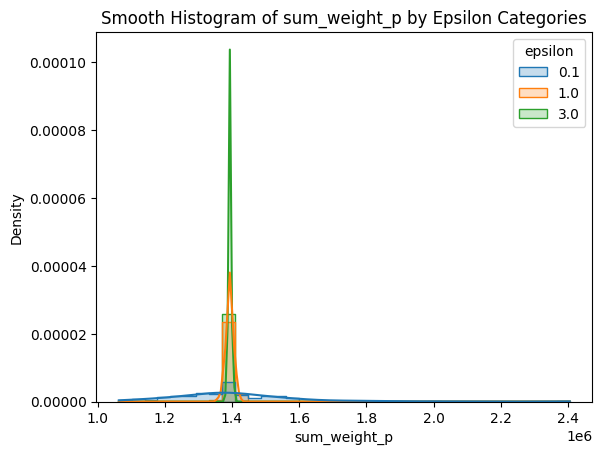

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing 'sum_weight_p' and categorical 'epsilon'

sns.histplot(
    data=pdf_neuch, 
    x='sum_weight_p', 
    hue='epsilon',        # separates data by epsilon categories with different colors
    kde=True,             # adds smooth Kernel Density Estimate curves
    element='step',       # outlines instead of filled bars for clarity
    stat='density',       # normalizes histogram as a density
    common_norm=False     # normalizes each group independently
)

plt.xlabel('sum_weight_p')
plt.ylabel('Density')
plt.title('Smooth Histogram of sum_weight_p by Epsilon Categories')
plt.show()


Test biais via le clamping